# Advanced Analytics in Fundraising
### How knowing donors helps in growing donors

Analytical basetable is composed of the population, the candidate predictors and the target

Population is a group of people or objects you want to make a prediction for (eg: donors). There is one row for each object of the population

The candidate predictors describes the objects and the populations. Information can be used to predict events. Age, gender or previous gifts can be used to predict whether someone who will donate for future projects

The target is an information about event to predict. 1 means that the event occurs and O otherwise. The target is whether the donor donated for a historical event 


In [293]:
!pip install scikit-plot

In [1]:
import sys
import pandas as pd
from pandas     import DataFrame
import numpy as np
import datetime as dt
from datetime import date 
import re

from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from scipy.stats.mstats import winsorize
from numpy                import array
from numpy                import random
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics      import auc
from sklearn.metrics      import roc_auc_score
from matplotlib           import pyplot as plt
from scipy.stats          import pearsonr
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model   import LogisticRegression
from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import RandomForestClassifier
from sklearn.ensemble       import GradientBoostingClassifier
from sklearn.svm            import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.metrics        import accuracy_score
from sklearn.metrics        import auc
from sklearn.metrics        import roc_auc_score
from matplotlib             import pyplot
import scikitplot as skplt

In [2]:
from ieseg import partition
from ieseg import roc
from ieseg import lift
from ieseg import cumulativeResponse
from ieseg import cumulativeGains

## READING THE DATA

In [3]:
campaigns = pd.read_csv('campaigns.csv', sep=";")
campaigns.head()

,campaignID,date,lettersSent,CostUnit
0,153,13/12/2004,6 873,"0,17 €"
1,154,01/01/2005,7 656,"0,30 €"
2,180,18/01/2005,9 933,"0,20 €"
3,433,29/01/2005,7 448,"0,59 €"
4,476,12/02/2005,6 605,"0,51 €"


In [4]:
campaigns[campaigns['campaignID']==6169]

,campaignID,date,lettersSent,CostUnit
335,6169,04/09/2018,34 888,"0,87 €"


In [5]:
len(campaigns)

367

In [6]:
campaigns.shape

(367, 4)

In [7]:
campaigns.isna().sum()

campaignID     0
date           0
lettersSent    0
CostUnit       0
dtype: int64

In [8]:
campaign6169 = pd.read_csv('selection campaign 6169.csv')
print(len(campaign6169))
campaign6169.head()

34888


,donorID
0,100001
1,100002
2,100004
3,100008
4,100009


In [9]:
campaign7244 = pd.read_csv('selection campaign 7244.csv')
campaign7244.head()
print(len(campaign7244))

25645


In [10]:
campaign7244.shape

(25645, 1)

In [6]:
#population
donors = pd.read_csv('donors.csv', sep=";")
donors.head()

FileNotFoundError: [Errno 2] File donors.csv does not exist: 'donors.csv'

In [ ]:
donors.province.unique()

In [5]:
donors.province.isna().sum()

NameError: name 'donors' is not defined

In [4]:
donors.isna().sum()

NameError: name 'donors' is not defined

In [154]:
print(donors[donors["zipcode"].isnull()])

       donorID  zipcode province   region gender language dateOfBirth
5019    105020      NaN  Missing  Missing      M       EN  1966-11-09
22100   122101      NaN  Missing  Missing      F       EN  1975-10-31


In [155]:
donors["zipcode"].isna().sum()

2

In [156]:
donors = donors.drop([5019, 22100])

In [157]:
donors["zipcode"].isna().sum()

0

In [158]:
donors["province"].isna().sum()

0

In [159]:
donors["region"].isna().sum()

0

In [160]:
population_size = len(donors)
population_size

44689

In [161]:
gifts = pd.read_csv('gifts.csv', sep=";")
gifts.head()

,donorID,campaignID,amount,date
0,100001,NaN,12.39,2004-03-23
1,100001,1577.0,12.39,2007-10-11
2,100001,1634.0,6.69,2007-12-28
3,100001,1778.0,24.79,2008-06-14
4,100001,1808.0,7.44,2008-07-09


In [162]:
gifts.shape

(216594, 4)

In [163]:
gifts.isna().sum()

donorID           0
campaignID    15637
amount            0
date              0
dtype: int64

In [164]:
gifts["date"] = pd.to_datetime(gifts["date"])
gifts.head()

,donorID,campaignID,amount,date
0,100001,NaN,12.39,2004-03-23
1,100001,1577.0,12.39,2007-10-11
2,100001,1634.0,6.69,2007-12-28
3,100001,1778.0,24.79,2008-06-14
4,100001,1808.0,7.44,2008-07-09


In [165]:
gifts.shape

(216594, 4)

In [166]:
gifts['amount'].mean()

57.50711648522261

In [167]:
gifts[gifts["date"].dt.year==2019]['amount'].mean()

33.390663289429206

In [168]:
min(gifts["date"].unique())

numpy.datetime64('2000-06-05T00:00:00.000000000')

In [169]:
max(gifts["date"].unique())

numpy.datetime64('2020-01-04T00:00:00.000000000')

## DEFINE TARGET

### -  Target Training set

In [170]:
#select donors from campaign 6169
gifts_target_training = gifts[gifts["campaignID"] == 6169]

print(len(gifts_target_training))


1191


In [171]:
target_training = gifts_target_training.groupby(["donorID"])["amount"].sum().reset_index()
target_training.columns = ["donorID", "amount"]
print(len(target_training))
target_training.head()

1191


,donorID,amount
0,100023,15.0
1,100126,123.0
2,100253,120.0
3,100279,75.0
4,100320,135.0


### - Target Test set

In [172]:
#select donors from campaign 7244
gifts_target_test = gifts[gifts["campaignID"] == 7244]
print(len(gifts_target_test))

361


In [173]:
target_test = gifts_target_test.groupby(["donorID"])["amount"].sum().reset_index()
target_test.columns = ["donorID", "amount"]
print(len(target_test))
target_test.head()

361


,donorID,amount
0,100724,40.0
1,100896,10.0
2,100964,100.0
3,101066,60.0
4,101069,80.0


## CREATE BASE TABLE

### - Predictive variables training set

In [35]:
#select historical data before the campaign 6169 started on 04-Sep-2018
reference6169 = dt.datetime(year=2018, month=9, day=4)

gifts_training = gifts[(gifts["date"] < reference6169)]

print(len(gifts_training))

208334


In [36]:
#Create aggregate variable
basetable_training = gifts_training .groupby(["donorID"])["amount"].agg(['max', 'min','mean','sum', 'count']).reset_index()
basetable_training.head()

,donorID,max,min,mean,sum,count
0,100001,30.00,6.69,14.874167,178.49,12
1,100002,20.00,20.00,20.000000,20.00,1
2,100003,5.00,3.00,3.600000,18.00,5
3,100004,49.58,24.79,27.546923,716.22,26
4,100005,5.00,2.48,3.740000,14.96,4


In [37]:
# Latest gift per donor
last_gift_training = gifts_training.groupby(["donorID"])["date"].max().reset_index()
last_gift_training["recency_days"] = reference6169 - last_gift_training["date"]   
last_gift_training["recency_days"] = last_gift_training.recency_days.apply(lambda x: x.days)
# Add recency to the basetable
basetable_training = pd.merge(basetable_training, last_gift_training[["donorID", "recency_days"]], how="left")

In [38]:
basetable_training.head()

,donorID,max,min,mean,sum,count,recency_days
0,100001,30.00,6.69,14.874167,178.49,12,2440
1,100002,20.00,20.00,20.000000,20.00,1,1333
2,100003,5.00,3.00,3.600000,18.00,5,58
3,100004,49.58,24.79,27.546923,716.22,26,2650
4,100005,5.00,2.48,3.740000,14.96,4,77


In [39]:
reference = dt.datetime(2018, 9, 4)
reference1 = dt.datetime(2018, 8, 4)

#gifts last month
gifts_last_month6169 = gifts_training[(gifts_training["date"] < reference) & (gifts_training["date"] >= reference1)]

last_month6169 = gifts_last_month6169.groupby("donorID")["amount"].mean().reset_index()
last_month6169.columns = ["donorID", "last_month_mean"]

basetable_training = pd.merge(basetable_training, last_month6169, how='left', on='donorID')

In [40]:
#Number of gifts in this period per donor
reference = dt.datetime(2018, 9, 4)
reference_y = dt.datetime(2017, 9, 4)

#gifts year 1
gifts_last_year6169 = gifts_training[(gifts_training["date"] < reference) & (gifts_training["date"] >= reference_y)]

year1_gifts_6169 = gifts_last_year6169.groupby("donorID")["amount"].agg(['mean', 'count']).reset_index()
year1_gifts_6169.columns = ["donorID", "year1_mean", "year1_count"]

basetable_training = pd.merge(basetable_training, year1_gifts_6169, how='left', on='donorID' )


In [41]:
#Number of gifts in this period per donor
reference_y1 = dt.datetime(2017, 9, 4)
reference_y2 = dt.datetime(2016, 9, 4)

#gifts last month
gifts_year2_6169 = gifts_training[(gifts_training["date"] < reference_y1) & (gifts_training["date"] >= reference_y2)]

year2_6169  = gifts_year2_6169.groupby("donorID")["amount"].agg(['mean', 'count']).reset_index()
year2_6169 .columns = ["donorID", "year2_mean", "year2_count"]

basetable_training = pd.merge(basetable_training, year2_6169, how='left', on='donorID' )
basetable_training.head()

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count
0,100001,30.00,6.69,14.874167,178.49,12,2440,NaN,NaN,NaN,NaN,NaN
1,100002,20.00,20.00,20.000000,20.00,1,1333,NaN,NaN,NaN,NaN,NaN
2,100003,5.00,3.00,3.600000,18.00,5,58,NaN,3.333333,3.0,4.0,2.0
3,100004,49.58,24.79,27.546923,716.22,26,2650,NaN,NaN,NaN,NaN,NaN
4,100005,5.00,2.48,3.740000,14.96,4,77,NaN,5.000000,1.0,5.0,1.0


In [42]:
#create different ratio :last month over the mean of past year donation
basetable_training["ratio_month_year"] = basetable_training["last_month_mean"] / basetable_training["year1_mean"]
#year to year donation ratio
basetable_training["ratio_year2year_mean"] = basetable_training["year1_mean"] / basetable_training["year2_mean"]
basetable_training["ratio_year2year_count"] = basetable_training["year1_count"] / basetable_training["year2_count"]
basetable_training.head(2)

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count,ratio_month_year,ratio_year2year_mean,ratio_year2year_count
0,100001,30.0,6.69,14.874167,178.49,12,2440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,20.0,20.00,20.000000,20.00,1,1333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
basetable_training.head()

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count,ratio_month_year,ratio_year2year_mean,ratio_year2year_count
0,100001,30.00,6.69,14.874167,178.49,12,2440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,20.00,20.00,20.000000,20.00,1,1333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100003,5.00,3.00,3.600000,18.00,5,58,NaN,3.333333,3.0,4.0,2.0,NaN,0.833333,1.5
3,100004,49.58,24.79,27.546923,716.22,26,2650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,5.00,2.48,3.740000,14.96,4,77,NaN,5.000000,1.0,5.0,1.0,NaN,1.000000,1.0


In [44]:
#create donors segmentation
basetable_training['segment'] = ''

for i in range(len(basetable_training)):
    if (basetable_training['mean'][i] > 1.5*(gifts_training["amount"].mean())) & (basetable_training['count'][i]>=5):
        basetable_training['segment'][i] = 'Gold'
    elif (basetable_training['mean'][i] >= (gifts_training["amount"].mean())) & (basetable_training['count'][i]>=3):
        basetable_training['segment'][i] = 'Silver'
    elif (basetable_training['mean'][i] > 0.5*(gifts_training["amount"].mean())) & (basetable_training['count'][i]>=3):
        basetable_training['segment'][i] = 'Bronze'
    else:
        basetable_training['segment'][i] = 'Regular'

In [45]:
gold_pop = basetable_training[basetable_training['segment']=='Gold']
silver_pop = basetable_training[basetable_training['segment']=='Silver']
bronze_pop = basetable_training[basetable_training['segment']=='Bronze']

In [46]:
donors["dateOfBirth"] = pd.to_datetime(donors["dateOfBirth"])

In [47]:
#calculate age training basetable
donors['age_6169'] = (reference6169 - donors['dateOfBirth'])
donors['age_6169'] = donors.age_6169.apply(lambda x: x.days)
donors['age_6169'] = round((donors['age_6169']/365),1)
donors.head(2)

,donorID,zipcode,province,region,gender,language,dateOfBirth,age_6169
0,100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,50.7
1,100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14,66.7


In [48]:
basetable_training = pd.merge(basetable_training,donors[["donorID","age_6169","gender","province", "language"]], on = "donorID", how = "left")

basetable_training.head(2)

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count,ratio_month_year,ratio_year2year_mean,ratio_year2year_count,segment,age_6169,gender,province,language
0,100001,30.0,6.69,14.874167,178.49,12,2440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,50.7,F,Flemish Brabant,NL
1,100002,20.0,20.00,20.000000,20.00,1,1333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,66.7,M,Antwerp,NL


#### Merge data set with campaign 6169 selection

In [49]:
basetable_training = pd.merge(campaign6169, basetable_training, on = "donorID", how = "left")
print(len(basetable_training))
basetable_training.head(2)

34888


,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count,ratio_month_year,ratio_year2year_mean,ratio_year2year_count,segment,age_6169,gender,province,language
0,100001,30.0,6.69,14.874167,178.49,12.0,2440.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,50.7,F,Flemish Brabant,NL
1,100002,20.0,20.00,20.000000,20.00,1.0,1333.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,66.7,M,Antwerp,NL


#### Create dummies variables

In [50]:
#Dummy variables for province, not need to creat columns for NA as they were originally replaced by missing
dummies_province = pd.get_dummies(basetable_training["province"], drop_first=True)
dummies_province .head()

,Brussels,East Flanders,Flemish Brabant,Hainaut,Liege,Limburg,Luxembourg,Namur,Walloon Brabant,West Flanders
0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


In [52]:
#Change dummy variable name
dummies_province.columns = ['prov_Br', 'prov_EaF', 'prov_FB', 'prov_Ha', 'prov_Liege', 'prov_Lim', 'prov_Lux', 'prov_Namur','prov_WaB', 'prov_WeF']
# Add the dummy variable to the basetable
basetable_training = pd.concat([basetable_training, dummies_province], axis=1)
# Delete the original variable from the basetable
del basetable_training["province"]

In [53]:
basetable_training.language.isna().sum()

21

In [54]:
#Dummy variables for language
dummies_language_training = pd.get_dummies(basetable_training["language"], drop_first=True, dummy_na=True)
dummies_language_training.head()

,FR,NL,NaN
0,0,1,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


In [55]:
#Change dummy variable name
dummies_language_training.columns = ['language_x', 'language_y','language_NaN']
# Add the dummy variable to the basetable
basetable_training = pd.concat([basetable_training, dummies_language_training], axis=1)
# Delete the original variable from the basetable
del basetable_training["language"]

In [56]:
#Dummy variables for segment
dummies_segment_training = pd.get_dummies(basetable_training["segment"], drop_first=True)
dummies_segment_training.head()

,Gold,Regular,Silver
0,0,1,0
1,0,1,0
2,0,1,0
3,0,0,0
4,0,1,0


In [57]:
#Change dummy variable name
dummies_segment_training.columns = ['segment_x', 'segment_y', 'segment_z']
# Add the dummy variable to the basetable
basetable_training = pd.concat([basetable_training, dummies_segment_training], axis=1)
# Delete the original variable from the basetable
del basetable_training["segment"]

In [58]:
basetable_training.gender.isna().sum()

41

In [59]:
# Create the dummy variable gender
dummies_gender_training = pd.get_dummies(basetable_training["gender"], drop_first=True, dummy_na=True)
dummies_gender_training.head()

,M,NaN
0,0,0
1,1,0
2,0,0
3,1,0
4,1,0


In [60]:
#Change dummy variable name
dummies_gender_training.columns = ['gender_x', 'gender_y']
# Add the dummy variable to the basetable
basetable_training = pd.concat([basetable_training, dummies_gender_training], axis=1)
# Delete the original variable from the basetable
del basetable_training["gender"]

In [61]:
basetable_training.head()

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,...,prov_WaB,prov_WeF,language_x,language_y,language_NaN,segment_x,segment_y,segment_z,gender_x,gender_y
0,100001,30.00,6.69,14.874167,178.49,12.0,2440.0,NaN,NaN,NaN,...,0,0,0,1,0,0,1,0,0,0
1,100002,20.00,20.00,20.000000,20.00,1.0,1333.0,NaN,NaN,NaN,...,0,0,0,1,0,0,1,0,1,0
2,100004,49.58,24.79,27.546923,716.22,26.0,2650.0,NaN,NaN,NaN,...,0,0,1,0,0,0,1,0,0,0
3,100008,50.00,24.79,41.456667,124.37,3.0,2503.0,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,1,0
4,100009,25.00,7.44,17.198947,326.78,19.0,2354.0,NaN,NaN,NaN,...,0,0,1,0,0,0,1,0,1,0


In [62]:
basetable_training.to_csv('basetable_training_Raw.csv')

#### - Replace missing values

In [63]:
#replace missing values by 0

basetable_training["last_month_mean"] = basetable_training["last_month_mean"].replace(np.nan, 0)
basetable_training["count"] = basetable_training["count"].replace(np.nan, 0)
basetable_training["year1_mean"] = basetable_training["year1_mean"].replace(np.nan, 0)
basetable_training["year1_count"] = basetable_training["year1_count"].replace(np.nan, 0)
basetable_training["year2_mean"] = basetable_training["year2_mean"].replace(np.nan, 0)
basetable_training["year2_count"] = basetable_training["year2_count"].replace(np.nan, 0)
basetable_training["ratio_month_year"] = basetable_training["ratio_month_year"].replace(np.nan, 0)
basetable_training["ratio_year2year_mean"] = basetable_training["ratio_year2year_mean"].replace(np.nan, 0)
basetable_training["ratio_year2year_count"] = basetable_training["ratio_year2year_count"].replace(np.nan, 0)


In [64]:
basetable_training["age_6169"].isna().sum()

21

In [65]:
#create new columns to identify missing value
basetable_training['age_NaN'] = basetable_training['age_6169'].isna()*1
basetable_training['age_NaN'].sum()

21

In [66]:
#replace missing age missing value with median
basetable_training["age_6169"].median()


47.3

In [67]:
basetable_training["age_6169"] = basetable_training["age_6169"].replace(np.nan, basetable_training["age_6169"].median())
basetable_training["age_6169"].isna().sum()

0

In [68]:
basetable_training["recency_days"].isna().sum()

19

In [69]:
#create new columns to identify missing value on the recency columns
basetable_training["recency_days_NaN"] = basetable_training["recency_days"].isna()*1
basetable_training["recency_days_NaN"].sum()

19

In [70]:
basetable_training["recency_days"] = basetable_training["recency_days"].replace(np.nan, basetable_training["recency_days"].median())
basetable_training["recency_days"].isna().sum()

0

In [71]:
basetable_training.head()

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,...,language_x,language_y,language_NaN,segment_x,segment_y,segment_z,gender_x,gender_y,age_NaN,recency_days_NaN
0,100001,30.00,6.69,14.874167,178.49,12.0,2440.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,0,0,0
1,100002,20.00,20.00,20.000000,20.00,1.0,1333.0,0.0,0.0,0.0,...,0,1,0,0,1,0,1,0,0,0
2,100004,49.58,24.79,27.546923,716.22,26.0,2650.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0
3,100008,50.00,24.79,41.456667,124.37,3.0,2503.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
4,100009,25.00,7.44,17.198947,326.78,19.0,2354.0,0.0,0.0,0.0,...,1,0,0,0,1,0,1,0,0,0


#### Dealing with outliers

In [72]:
# Show the maximum age 

print(basetable_training["age_6169"].max())
print(basetable_training["age_6169"].min())

129.3
20.2


In [73]:
#Dealing with outliers in the variable age

# Calculate mean and standard deviation of age
mean_age6169 = basetable_training["age_6169"].mean()
std_age6169 = basetable_training["age_6169"].std()

# Calculate the lower and upper limits
lower_limit6169 = mean_age6169 - std_age6169 * 3
upper_limit6169 = mean_age6169 + std_age6169 * 3

# Add a variable age_no_outliers to the basetable with outliers replaced
basetable_training["age_no_outliers"] = (pd.Series([min(max(a, lower_limit6169), upper_limit6169) 
                             for a in basetable_training["age_6169"]]))
print(basetable_training["age_no_outliers"].max())

96.78773347948696


In [74]:
#Delete previous age columns
del basetable_training["age_6169"]

In [75]:
# Check minimum and max mean of donations
print(basetable_training["mean"].min())
print(basetable_training["mean"].max())


0.6211764705882361
2479000.0


In [76]:
# Fill out the lower limit
lower_limit6169 = 0.0

# Winsorize the variable sum_donations
basetable_training["mean"] = winsorize(basetable_training["mean"], limits=[lower_limit6169, 0.01])

# Check maximum sum of donations after winsorization
print(basetable_training["mean"].max())

123.95


In [77]:
# Check minimum, maximum sum of donations
print(basetable_training["sum"].min())
print(basetable_training["sum"].max())

5.0
4000030.0


In [78]:
# Fill out the lower limit
lower_limit6169 = 0.0

# Winsorize the variable sum_donations
basetable_training["sum"] = winsorize(basetable_training["sum"], limits=[lower_limit6169, 0.01])

# Check maximum sum of donations after winsorization
print(basetable_training["sum"].max())

1027.5900000000001


In [79]:
# Check min and max of min amount of donations per donors
print(basetable_training["min"].min())
print(basetable_training["min"].max())

0.1
2479000.0


In [80]:
# Fill out the lower limit
lower_limit6169 = 0.0

# Winsorize the variable sum_donations
basetable_training["min"] = winsorize(basetable_training["min"], limits=[lower_limit6169, 0.01])

# Check maximum sum of donations after winsorization
print(basetable_training["min"].max())

100.0


In [81]:
# Check min and max of max amount of donations per donors
print(basetable_training["max"].min())
print(basetable_training["max"].max())

5.0
4000000.0


In [82]:
# Fill out the lower limit
lower_limit6169 = 0.0

# Winsorize the variable sum_donations
basetable_training["max"] = winsorize(basetable_training["max"], limits=[lower_limit6169, 0.01])

# Check maximum sum of donations after winsorization
print(basetable_training["max"].max())

200.0


#### ADD target variables to the base table

In [83]:
#derive targets and add to the basetables

target = list(target_training["donorID"][target_training["amount"] > 0])

basetable_training["target"] = pd.Series([1 if donorID in target else 0 for donorID in basetable_training["donorID"]])
basetable_training.head()

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,...,language_NaN,segment_x,segment_y,segment_z,gender_x,gender_y,age_NaN,recency_days_NaN,age_no_outliers,target
0,100001,30.00,6.69,14.874167,178.49,12.0,2440.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,50.7,0
1,100002,20.00,20.00,20.000000,20.00,1.0,1333.0,0.0,0.0,0.0,...,0,0,1,0,1,0,0,0,66.7,0
2,100004,49.58,24.79,27.546923,716.22,26.0,2650.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,66.5,0
3,100008,50.00,24.79,41.456667,124.37,3.0,2503.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,81.1,0
4,100009,25.00,7.44,17.198947,326.78,19.0,2354.0,0.0,0.0,0.0,...,0,0,1,0,1,0,0,0,86.7,0


In [84]:
# Target incidences
print(round(sum(basetable_training["target"]) / len(basetable_training), 3))


0.034


In [85]:

basetable_training.isna().sum().sum()


0

In [86]:
basetable_training.to_csv('basetable_training_Processed-data.csv')

### -  Predictive variables test set

In [87]:
reference7244 = dt.datetime(year=2019, month=6, day=18)

gifts_test = gifts[(gifts["date"] < reference7244)]

print(len(gifts_test))

214231


In [88]:
#create aggregate variable
basetable_test = gifts_test.groupby(["donorID"])["amount"].agg(['max', 'min','mean','sum', 'count']).reset_index()
basetable_test.head()

,donorID,max,min,mean,sum,count
0,100001,30.00,6.69,14.874167,178.49,12
1,100002,20.00,20.00,20.000000,20.00,1
2,100003,5.00,3.00,3.833333,46.00,12
3,100004,49.58,24.79,27.546923,716.22,26
4,100005,10.00,2.48,4.992000,24.96,5


In [89]:
# Latest gift per donor
last_gift_test = gifts_test.groupby(["donorID"])["date"].max().reset_index()
last_gift_test["recency_days"] = reference7244 - last_gift_test["date"]   
last_gift_test["recency_days"] = last_gift_test.recency_days.apply(lambda x: x.days)
# Add recency to the basetable
basetable_test = pd.merge(basetable_test, last_gift_test[["donorID", "recency_days"]], how="left")

In [90]:
basetable_test.head()

,donorID,max,min,mean,sum,count,recency_days
0,100001,30.00,6.69,14.874167,178.49,12,2727
1,100002,20.00,20.00,20.000000,20.00,1,1620
2,100003,5.00,3.00,3.833333,46.00,12,1
3,100004,49.58,24.79,27.546923,716.22,26,2937
4,100005,10.00,2.48,4.992000,24.96,5,61


In [91]:
reference = dt.datetime(2019, 6, 18)
reference1 = dt.datetime(2019, 5, 18)

#gifts last month
gifts_last_month7244 = gifts_test[(gifts_test["date"] <= reference) & (gifts_test["date"] >= reference1)]

last_month7244 = gifts_last_month7244.groupby("donorID")["amount"].mean().reset_index()
last_month7244.columns = ["donorID", "last_month_mean"]

basetable_test = pd.merge(basetable_test, last_month7244, how='left', on='donorID')

In [92]:
#Number of gifts in this period per donor
reference = dt.datetime(2019, 6, 18)
reference_y = dt.datetime(2018, 6, 18)

#gifts last month
gifts_last_year7244 = gifts_test[(gifts_test["date"] <= reference) & (gifts_test["date"] >= reference_y)]

year1_gifts_7244 = gifts_last_year7244.groupby("donorID")["amount"].agg(['mean','count']).reset_index()
year1_gifts_7244.columns = ["donorID", "year1_mean", "year1_count"]

basetable_test = pd.merge(basetable_test, year1_gifts_7244, how='left', on='donorID' )


In [93]:
#Number of gifts in this period per donor
reference_y1 = dt.datetime(2018, 6, 18)
reference_y2 = dt.datetime(2017, 6, 18)

#gifts last month
gifts_last_year7244 = gifts_test[(gifts_test["date"] < reference_y1) & (gifts_test["date"] >= reference_y2)]

year2_gifts_7244 = gifts_last_year7244.groupby("donorID")["amount"].agg(['mean','count']).reset_index()
year2_gifts_7244.columns = ["donorID", "year2_mean", "year2_count"]

basetable_test = pd.merge(basetable_test, year2_gifts_7244, how='left', on='donorID' )
basetable_test.head()

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count
0,100001,30.00,6.69,14.874167,178.49,12,2727,NaN,NaN,NaN,NaN,NaN
1,100002,20.00,20.00,20.000000,20.00,1,1620,NaN,NaN,NaN,NaN,NaN
2,100003,5.00,3.00,3.833333,46.00,12,1,4.0,3.875,8.0,3.75,4.0
3,100004,49.58,24.79,27.546923,716.22,26,2937,NaN,NaN,NaN,NaN,NaN
4,100005,10.00,2.48,4.992000,24.96,5,61,NaN,7.500,2.0,NaN,NaN


In [94]:
#create different ratio :last month over the mean of past year donation
basetable_test["ratio_month_year"] = basetable_test["last_month_mean"] / basetable_test["year1_mean"]
#create year to year ratio
basetable_test["ratio_year2year_mean"] = basetable_test["year1_mean"] / basetable_test["year2_mean"]
basetable_test["ratio_year2year_count"] = basetable_test["year1_count"] / basetable_test["year2_count"]


In [95]:
basetable_test.head()

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count,ratio_month_year,ratio_year2year_mean,ratio_year2year_count
0,100001,30.00,6.69,14.874167,178.49,12,2727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,20.00,20.00,20.000000,20.00,1,1620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100003,5.00,3.00,3.833333,46.00,12,1,4.0,3.875,8.0,3.75,4.0,1.032258,1.033333,2.0
3,100004,49.58,24.79,27.546923,716.22,26,2937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,10.00,2.48,4.992000,24.96,5,61,NaN,7.500,2.0,NaN,NaN,NaN,NaN,NaN


In [96]:
#create segmentation of our donor based on below criteria
basetable_test['segment'] = ''

for i in range(len(basetable_test)):
    if (basetable_test['mean'][i] > 1.5*(gifts_test["amount"].mean())) & (basetable_test['count'][i]>=5):
        basetable_test['segment'][i] = 'Gold'
    elif (basetable_test['mean'][i] >= (gifts_test["amount"].mean())) & (basetable_test['count'][i]>=3):
        basetable_test['segment'][i] = 'Silver'
    elif (basetable_test['mean'][i] > 0.5*(gifts_test["amount"].mean())) & (basetable_test['count'][i]>=3):
        basetable_test['segment'][i] = 'Bronze'
    else:
        basetable_test['segment'][i] = 'Regular'

In [97]:
gold_pop_test= basetable_test[basetable_test['segment']=='Gold']
silver_pop_test = basetable_test[basetable_test['segment']=='Silver']
bronze_pop_test = basetable_test[basetable_test['segment']=='Bronze']

In [98]:
donors["dateOfBirth"] = pd.to_datetime(donors["dateOfBirth"])

In [99]:
#calculate age test basetable
donors['age_7244'] = (reference7244 - donors['dateOfBirth'])
donors['age_7244'] = donors.age_7244.apply(lambda x: x.days)
donors['age_7244'] = round((donors['age_7244']/365),1)
donors.head()

,donorID,zipcode,province,region,gender,language,dateOfBirth,age_6169,age_7244
0,100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,50.7,51.5
1,100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14,66.7,67.5
2,100003,1780.0,Flemish Brabant,Flanders,M,NL,1986-12-23,31.7,32.5
3,100004,1020.0,Brussels,Brussels,F,FR,1952-03-29,66.5,67.3
4,100005,1020.0,Brussels,Brussels,F,FR,1986-06-25,32.2,33.0


In [100]:
basetable_test = pd.merge(basetable_test,donors[["donorID","age_7244","gender","province", "language"]], on = "donorID", how = "left")

basetable_test.head(2)

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count,ratio_month_year,ratio_year2year_mean,ratio_year2year_count,segment,age_7244,gender,province,language
0,100001,30.0,6.69,14.874167,178.49,12,2727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,51.5,F,Flemish Brabant,NL
1,100002,20.0,20.00,20.000000,20.00,1,1620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,67.5,M,Antwerp,NL


#### Merge data set with campaign 7244 selection

In [101]:
basetable_test = pd.merge(campaign7244, basetable_test, on = "donorID", how = "left")
print(len(basetable_test))
basetable_test.head(2)

25645


,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count,ratio_month_year,ratio_year2year_mean,ratio_year2year_count,segment,age_7244,gender,province,language
0,100001,30.0,6.69,14.874167,178.49,12.0,2727.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,51.5,F,Flemish Brabant,NL
1,100002,20.0,20.00,20.000000,20.00,1.0,1620.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,67.5,M,Antwerp,NL


#### Create dummies variables

In [102]:
#Dummy variables for region, no missing value created as it was replace initally by missing
dummies_province_test = pd.get_dummies(basetable_test["province"], drop_first=True)
dummies_province_test .head()

,Brussels,East Flanders,Flemish Brabant,Hainaut,Liege,Limburg,Luxembourg,Namur,Walloon Brabant,West Flanders
0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


In [103]:
#Change dummy variable name
dummies_province_test.columns = ['prov_Br', 'prov_EaF', 'prov_FB', 'prov_Ha', 'prov_Liege', 'prov_Lim', 'prov_Lux','prov_Namur','prov_WaB', 'prov_WeF']
# Add the dummy variable to the basetable
basetable_test = pd.concat([basetable_test, dummies_province_test], axis=1)
# Delete the original variable from the basetable
del basetable_test["province"]

In [104]:
basetable_test.language.isna().sum()

2

In [105]:
#Dummy variables for language
dummies_language_test = pd.get_dummies(basetable_test["language"], drop_first=True, dummy_na=True)
dummies_language_test.head()

,FR,NL,NaN
0,0,1,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


In [106]:
#Change dummy variable name
dummies_language_test.columns = ['language_x', 'language_y', 'language_NaN']
# Add the dummy variable to the basetable
basetable_test = pd.concat([basetable_test, dummies_language_test], axis=1)
# Delete the original variable from the basetable
del basetable_test["language"]

In [107]:
#Dummy variables for segment
dummies_segment_test = pd.get_dummies(basetable_test["segment"], drop_first=True)
dummies_segment_test.head()

,Gold,Regular,Silver
0,0,1,0
1,0,1,0
2,0,0,0
3,0,1,0
4,0,1,0


In [108]:
#Change dummy variable name
dummies_segment_test.columns = ['segment_x', 'segment_y', 'segment_z']
# Add the dummy variable to the basetable
basetable_test = pd.concat([basetable_test, dummies_segment_test], axis=1)
# Delete the original variable from the basetable
del basetable_test["segment"]

In [109]:
# Create the dummy variable gender
dummies_gender_test = pd.get_dummies(basetable_test["gender"], drop_first=True, dummy_na=True)
dummies_gender_test.head()

,M,NaN
0,0,0
1,1,0
2,1,0
3,1,0
4,1,0


In [110]:
#Change dummy variable name
dummies_gender_test.columns = ['gender_x', 'gender_y']
# Add the dummy variable to the basetable
basetable_test = pd.concat([basetable_test, dummies_gender_test], axis=1)
# Delete the original variable from the basetable
del basetable_test["gender"]

#### Replace missing values

In [111]:
#replace missing values by 0

basetable_test["last_month_mean"] = basetable_test["last_month_mean"].replace(np.nan, 0)
basetable_test["count"] = basetable_test["count"].replace(np.nan, 0)
basetable_test["year1_mean"] = basetable_test["year1_mean"].replace(np.nan, 0)
basetable_test["year1_count"] = basetable_test["year1_count"].replace(np.nan, 0)
basetable_test["year2_mean"] = basetable_test["year2_mean"].replace(np.nan, 0)
basetable_test["year2_count"] = basetable_test["year2_count"].replace(np.nan, 0)
basetable_test["ratio_month_year"] = basetable_test["ratio_month_year"].replace(np.nan, 0)
basetable_test["ratio_year2year_mean"] = basetable_test["ratio_year2year_mean"].replace(np.nan, 0)
basetable_test["ratio_year2year_count"] = basetable_test["ratio_year2year_count"].replace(np.nan, 0)

In [112]:
basetable_test['age_7244'].isna().sum()

2

In [113]:
#create missing value columns for the age 
basetable_test['age_NaN'] = basetable_test['age_7244'].isna()*1
basetable_test['age_NaN'].sum()

2

In [114]:
#replace missing value of the age by the median
basetable_test["age_7244"] = basetable_test["age_7244"].replace(np.nan, basetable_test["age_7244"].median())


In [115]:
basetable_test['age_7244'].isna().sum()

0

In [116]:
basetable_test["recency_days"].isna().sum()

1

In [117]:
#create missing value columns for the age
basetable_test["recency_days_NaN"] = basetable_test['recency_days'].isna()*1
basetable_test["recency_days_NaN"].sum()

1

In [118]:
basetable_test["recency_days"] = basetable_test["recency_days"].replace(np.nan, basetable_test["recency_days"].median())
basetable_test['recency_days'].isna().sum()

0

#### Dealing with outliers

In [119]:
# Show the maximum age 

print(basetable_test["age_7244"].max())
print(basetable_test["age_7244"].min())

130.1
21.0


In [120]:
#Dealing with outliers in the variable age

# Calculate mean and standard deviation of age
mean_age7244 = basetable_test["age_7244"].mean()
std_age7244 = basetable_test["age_7244"].std()

# Calculate the lower and upper limits
lower_limit7244 = mean_age7244 - std_age7244 * 3
upper_limit7244 = mean_age7244 + std_age7244 * 3

# Add a variable age_no_outliers to the basetable with outliers replaced
basetable_test["age_no_outliers"] = (pd.Series([min(max(a, lower_limit7244), upper_limit7244) 
                             for a in basetable_test["age_7244"]]))
print(basetable_test["age_no_outliers"].max())

97.21712568656139


In [121]:
#Delete previous age columns
del basetable_test["age_7244"]

In [122]:
# Check minimum mean of donations
print(basetable_test["mean"].min())
print(basetable_test["mean"].max())

0.6211764705882361
2479000.0


In [123]:
# Fill out the lower limit
lower_limit7244 = 0.0

# Winsorize the variable sum_donations
basetable_test["mean"] = winsorize(basetable_test["mean"], limits=[lower_limit7244, 0.01])

# Check maximum sum of donations after winsorization
print(basetable_test["mean"].max())

120.66666666666667


In [124]:
# Check minimum, maximum sum of donations
print(basetable_test["sum"].min())
print(basetable_test["sum"].max())

5.0
4000030.0


In [125]:
# Fill out the lower limit
lower_limit7244 = 0.0

# Winsorize the variable sum_donations
basetable_test["sum"] = winsorize(basetable_test["sum"], limits=[lower_limit7244, 0.01])

# Check maximum sum of donations after winsorization
print(basetable_test["sum"].max())

991.5699999999999


In [126]:
# Check min and max of min amount of donations per donors
print(basetable_test["min"].min())
print(basetable_test["min"].max())

0.13
2479000.0


In [127]:
# Fill out the lower limit
lower_limit7244 = 0.0

# Winsorize the variable sum_donations
basetable_test["min"] = winsorize(basetable_test["min"], limits=[lower_limit7244, 0.01])

# Check maximum sum of donations after winsorization
print(basetable_test["min"].max())

100.0


In [128]:
# Check min and max of max amount of donations per donors
print(basetable_test["max"].min())
print(basetable_test["max"].max())

5.0
4000000.0


In [129]:
# Fill out the lower limit
lower_limit7244 = 0.0

# Winsorize the variable sum_donations
basetable_test["max"] = winsorize(basetable_test["max"], limits=[lower_limit7244, 0.01])

# Check maximum sum of donations after winsorization
print(basetable_test["max"].max())

200.0


#### ADD Target variables to the base table

In [130]:
#derive targets and add to the basetables

target = list(target_test["donorID"][target_test["amount"] > 0])

basetable_test["target"] = pd.Series([1 if donorID in target else 0 for donorID in basetable_test["donorID"]])
basetable_test.head()

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,...,language_NaN,segment_x,segment_y,segment_z,gender_x,gender_y,age_NaN,recency_days_NaN,age_no_outliers,target
0,100001,30.0,6.69,14.874167,178.49,12.0,2727.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,51.5,0
1,100002,20.0,20.00,20.000000,20.00,1.0,1620.0,0.0,0.0,0.0,...,0,0,1,0,1,0,0,0,67.5,0
2,100008,50.0,24.79,41.456667,124.37,3.0,2790.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,81.9,0
3,100009,25.0,7.44,17.198947,326.78,19.0,2641.0,0.0,0.0,0.0,...,0,0,1,0,1,0,0,0,87.5,0
4,100010,40.0,40.00,40.000000,40.00,1.0,1617.0,0.0,0.0,0.0,...,0,0,1,0,1,0,0,0,36.1,0


In [131]:
# Target incidences
print(round(sum(basetable_test["target"]) / len(basetable_test), 3))

0.014


In [132]:
basetable_test.isna().sum().sum()

0

In [133]:
basetable_test.to_csv('basetable_test_Processed-data.csv')

### reading processed data 

In [11]:
basetable_training= pd.read_csv('basetable_training_Processed-data.csv', sep=',')

In [12]:
basetable_test= pd.read_csv('basetable_test_Processed-data.csv', sep=',')

In [13]:
basetable_training

,Unnamed: 0,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,...,language_NaN,segment_x,segment_y,segment_z,gender_x,gender_y,age_NaN,recency_days_NaN,age_no_outliers,target
0,0,100001,30.00,6.69,14.874167,178.49,12.0,2440.0,0.0,0.0,...,0,0,1,0,0,0,0,0,50.7,0
1,1,100002,20.00,20.00,20.000000,20.00,1.0,1333.0,0.0,0.0,...,0,0,1,0,1,0,0,0,66.7,0
2,2,100004,49.58,24.79,27.546923,716.22,26.0,2650.0,0.0,0.0,...,0,0,1,0,0,0,0,0,66.5,0
3,3,100008,50.00,24.79,41.456667,124.37,3.0,2503.0,0.0,0.0,...,0,0,0,0,1,0,0,0,81.1,0
4,4,100009,25.00,7.44,17.198947,326.78,19.0,2354.0,0.0,0.0,...,0,0,1,0,1,0,0,0,86.7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34883,34883,144686,50.00,50.00,50.000000,50.00,1.0,1225.0,0.0,0.0,...,0,0,1,0,0,0,0,0,54.0,0
34884,34884,144687,10.00,10.00,10.000000,10.00,1.0,1033.0,0.0,0.0,...,0,0,1,0,1,0,0,0,48.0,0
34885,34885,144689,100.00,24.79,62.395000,124.79,2.0,71.0,0.0,100.0,...,0,0,1,0,1,0,0,0,51.4,0
34886,34886,144690,40.00,40.00,40.000000,40.00,1.0,1344.0,0.0,0.0,...,0,0,1,0,1,0,0,0,42.4,0


In [ ]:
featurues = 

## Variable selection

#### Set the features and target

In [66]:
basetable_training.columns

Index(['Unnamed: 0', 'donorID', 'max', 'min', 'mean', 'sum', 'count',
       'recency_days', 'last_month_mean', 'year1_mean', 'year1_count',
       'year2_mean', 'year2_count', 'ratio_month_year', 'ratio_year2year_mean',
       'ratio_year2year_count', 'prov_Br', 'prov_EaF', 'prov_FB', 'prov_Ha',
       'prov_Liege', 'prov_Lim', 'prov_Lux', 'prov_Namur', 'prov_WaB',
       'prov_WeF', 'language_x', 'language_y', 'language_NaN', 'segment_x',
       'segment_y', 'segment_z', 'gender_x', 'gender_y', 'age_NaN',
       'recency_days_NaN', 'age_no_outliers', 'target', 'proba_stepwise'],
      dtype='object')

In [67]:
all_features = basetable_training.columns[2:-2]
target = "target"

In [68]:
all_features 

Index(['max', 'min', 'mean', 'sum', 'count', 'recency_days', 'last_month_mean',
       'year1_mean', 'year1_count', 'year2_mean', 'year2_count',
       'ratio_month_year', 'ratio_year2year_mean', 'ratio_year2year_count',
       'prov_Br', 'prov_EaF', 'prov_FB', 'prov_Ha', 'prov_Liege', 'prov_Lim',
       'prov_Lux', 'prov_Namur', 'prov_WaB', 'prov_WeF', 'language_x',
       'language_y', 'language_NaN', 'segment_x', 'segment_y', 'segment_z',
       'gender_x', 'gender_y', 'age_NaN', 'recency_days_NaN',
       'age_no_outliers'],
      dtype='object')

### Model instanciation

In [69]:
model = GradientBoostingClassifier()

### Use stepwise regression to select the features

In [70]:
def stepwiseRegresion (trainingSet: DataFrame, testSet: DataFrame, all_features: [str], target: [str]) -> DataFrame:

    def computeAUC (forFeatures: [str]) -> ([str],float,float):
    
        model.fit(trainingSet[forFeatures], trainingSet[target])

        trainingSet["proba_stepwise"] = DataFrame(model.predict_proba(trainingSet[forFeatures]))[1]
        testSet["proba_stepwise"]     = DataFrame(model.predict_proba(testSet[forFeatures]))[1]

        aucTraining = roc_auc_score(array(trainingSet[target]),array(trainingSet["proba_stepwise"]))
        aucTest     = roc_auc_score(array(testSet[target]),array(testSet["proba_stepwise"]))

        trainingSet.drop("proba_stepwise", axis = 1)
        testSet.drop("proba_stepwise", axis = 1)

        return (forFeatures,aucTraining,aucTest)

    featuresOrder = []
    forwardSelection = []

    for step in range(len(all_features)):
        print(f"step {step+1}")
        aucs = []
        for feature in all_features:
            if feature not in featuresOrder:
                modelFeatures = featuresOrder.copy()
                modelFeatures.append(feature)
                aucs.append(computeAUC(forFeatures = modelFeatures))

        steps = DataFrame(aucs)
        steps.columns = ["Feature","AUC training", "AUC test"]
        steps = steps.sort_values(by=["AUC test"], ascending = False)

        featuresOrder = steps["Feature"].iloc[0]
        forwardSelection.append((step+1, steps["Feature"].iloc[0],steps["AUC training"].iloc[0],steps["AUC test"].iloc[0]))

    df = DataFrame(forwardSelection)
    df.columns = ("Step","Features","AUC Train","AUC Test")
    
    return df

In [71]:

forwardSelection = stepwiseRegresion(trainingSet      = basetable_training, 
                                     testSet          = basetable_test,
                                     all_features     = all_features,
                                     target           = target)

step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35


In [72]:
forwardSelection


,Step,Features,AUC Train,AUC Test
0,1,[min],0.992552,0.751236
1,2,"[min, ratio_year2year_mean]",0.991811,0.755167
2,3,"[min, ratio_year2year_mean, prov_FB]",0.991287,0.758749
3,4,"[min, ratio_year2year_mean, prov_FB, last_mont...",0.991189,0.760594
4,5,"[min, ratio_year2year_mean, prov_FB, last_mont...",0.991269,0.760638
5,6,"[min, ratio_year2year_mean, prov_FB, last_mont...",0.991254,0.760662
6,7,"[min, ratio_year2year_mean, prov_FB, last_mont...",0.991255,0.760677
7,8,"[min, ratio_year2year_mean, prov_FB, last_mont...",0.991255,0.760677
8,9,"[min, ratio_year2year_mean, prov_FB, last_mont...",0.991255,0.760677
9,10,"[min, ratio_year2year_mean, prov_FB, last_mont...",0.991255,0.760677


In [97]:
#selectedpredictors
selectedpredictors = forwardSelection['Features'][11]
selectedpredictors

['min',
 'ratio_year2year_mean',
 'prov_FB',
 'last_month_mean',
 'prov_Br',
 'prov_Liege',
 'prov_Ha',
 'prov_Lux',
 'prov_Namur',
 'segment_x',
 'ratio_month_year',
 'prov_WeF']

In [ ]:
selectedpredictors = ['min',
 'segment_z',
 'prov_Ha',
 'recency_days_NaN',
 'prov_Br',
 'prov_Lim',
 'prov_Lux']

### Run the model on training set

#### Model instanciation

In [98]:
features = selectedpredictors

target   = "target"

In [99]:
tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(solver = "lbfgs", max_iter = 1000)
randomForest = RandomForestClassifier(n_estimators = 100)
boostedTree  = GradientBoostingClassifier()
svm          = SVC(gamma = "scale", probability = True)
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()

In [100]:
models = {"tree"         :tree,
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          "svm"          :svm,
          "neuralNet"    :neuralNet,
          "neighbors"    :neighbors
         }

#### Train the model on the training set

In [101]:
for model in models:
    models[model].fit(basetable_training[features],basetable_training[target])
    print(f"{model} has been trained successfully")

tree has been trained successfully
logistic has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
svm has been trained successfully
neuralNet has been trained successfully
neighbors has been trained successfully


### Evaluate the model

In [102]:
performances = {}

for model in models:
    predictions   = models[model].predict(basetable_training[features])
    probabilities = DataFrame(models[model].predict_proba(basetable_training[features]))[1]
    accuracy      = accuracy_score(basetable_training[target],predictions)
    auc           = roc_auc_score(array(basetable_training[target]),array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

In [103]:
DataFrame(performances)

,tree,logistic,randomForest,boostedTree,svm,neuralNet,neighbors
Accuracy,0.993293,0.96569,0.993293,0.988563,0.965862,0.965834,0.987503
AUC,0.998283,0.54665,0.997955,0.991257,0.535503,0.565266,0.993222


### selected model

In [104]:
boostedTree  = GradientBoostingClassifier()

### Evaluate the model on the test set

In [121]:
features = selectedpredictors 
target   = "target"

In [122]:
boostedTree.fit(basetable_training[features],basetable_training[target])

GradientBoostingClassifier()

In [123]:
    predictions_test   = boostedTree.predict(basetable_test[features])
    probabilities_test = DataFrame(boostedTree.predict_proba(basetable_test[features]))[1]
    accuracy_test      = accuracy_score(basetable_test[target],predictions_test)
    auc_test           = roc_auc_score(array(basetable_test[target]),array(probabilities_test))
    

In [124]:
auc_test

0.760675786774157

In [125]:
len(predictions_test)

25645

In [126]:
accuracy_test

0.9828426593877949

In [127]:
predictions_test.sum()

93

In [128]:
basetable_test.target.sum()

361

### Cummulative gain curve

In [132]:
features_selected = selectedpredictors

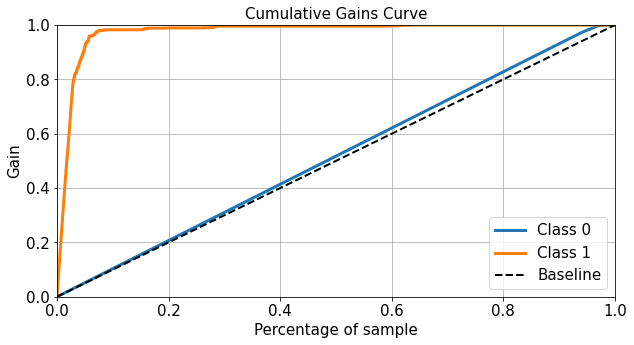

In [133]:
features_select = basetable_training[features_selected]
target = basetable_training["target"]

X = features_select
y = target

logreg = GradientBoostingClassifier()

logreg.fit(X,y)

predictions = logreg.predict_proba(X)

skplt.metrics.plot_cumulative_gain(y, predictions, figsize=(10,5), title_fontsize=15, text_fontsize=15)
plt.show()

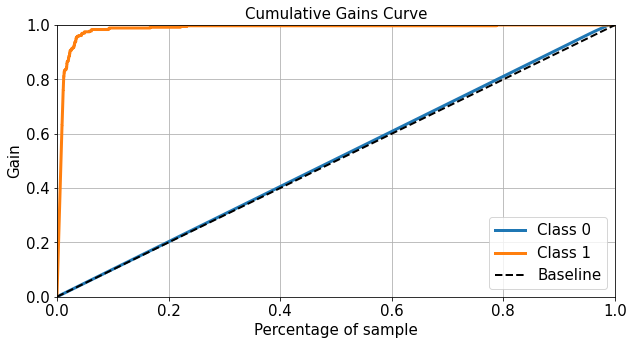

In [134]:
features_select = basetable_test[features_selected]
target = basetable_test["target"]

X = features_select
y = target

logreg = GradientBoostingClassifier()

logreg.fit(X,y)

predictions = logreg.predict_proba(X)

skplt.metrics.plot_cumulative_gain(y, predictions, figsize=(10,5), title_fontsize=15, text_fontsize=15)
plt.show()

In [137]:
data      = DataFrame(basetable_test['target']).copy() 

data['proba_logistic'] = DataFrame(boostedTree.predict_proba(basetable_test[features_selected]))[1]
lifts = lift(dataSet = data, actuals = "target", probability = 'proba_logistic')
responses = cumulativeResponse(dataSet = data, actuals = "target", probability = 'proba_logistic')
gains = cumulativeGains(dataSet = data, actuals = "target", probability = 'proba_logistic')

In [138]:
lifts


,Quantile,Lift,Base
10,1.00,4.091239,1.0
9,0.95,2.562988,1.0
8,0.90,2.665427,1.0
7,0.85,2.243849,1.0
6,0.80,2.001545,1.0
5,0.75,2.395390,1.0
4,0.70,1.765909,1.0
3,0.55,1.375964,1.0
2,0.45,1.342479,1.0
1,0.40,1.226036,1.0


In [139]:
lifts.to_csv('lifts_curves_booostedtree.csv')

In [140]:
responses.to_csv('responses_curves_booostedtree.csv')

In [141]:
gains.to_csv('gains_curves_booostedtree.csv')

### Prediction of Unseen DATA

In [175]:
#reading data
campaigns_7662 = pd.read_csv('selection campaign 7662.csv')
campaigns_7662.head()

,donorID
0,134242
1,126503
2,104392
3,105905
4,120506


In [176]:
len(campaigns_7662)

26522

In [177]:
#15th of December 2020
reference7662 = dt.datetime(year=2020, month=12, day=15)

gifts_data = gifts[(gifts["date"] < reference7662)]

print(len(gifts_data))

216594


In [178]:
basetable = gifts_data.groupby(["donorID"])["amount"].agg(['max', 'min','mean','sum', 'count']).reset_index()
basetable.head()

,donorID,max,min,mean,sum,count
0,100001,30.00,6.69,14.874167,178.49,12
1,100002,20.00,20.00,20.000000,20.00,1
2,100003,5.00,3.00,3.833333,46.00,12
3,100004,49.58,24.79,27.546923,716.22,26
4,100005,10.00,2.48,4.992000,24.96,5


In [179]:
# Latest gift per donor
last_gift_data = gifts_data.groupby(["donorID"])["date"].max().reset_index()
last_gift_data["recency_days"] = reference7662 - last_gift_data["date"]   
last_gift_data["recency_days"] = last_gift_data.recency_days.apply(lambda x: x.days)
# Add recency to the basetable
basetable = pd.merge(basetable, last_gift_data[["donorID", "recency_days"]], how="left")

In [180]:
reference = dt.datetime(2020, 12, 15)
reference1 = dt.datetime(2020, 11, 15)

#gifts last month
gifts_last_month7662 = gifts_data[(gifts_data["date"] <= reference) & (gifts_data["date"] >= reference1)]

last_month7662 = gifts_last_month7662.groupby("donorID")["amount"].mean().reset_index()
last_month7662.columns = ["donorID", "last_month_mean"]

basetable = pd.merge(basetable, last_month7662, how='left', on='donorID')

In [181]:
basetable.head(2)

,donorID,max,min,mean,sum,count,recency_days,last_month_mean
0,100001,30.0,6.69,14.874167,178.49,12,3273,NaN
1,100002,20.0,20.00,20.000000,20.00,1,2166,NaN


In [182]:
#Number of gifts in this period per donor
reference = dt.datetime(2020, 12, 15)
reference_y = dt.datetime(2019, 12, 15)

#gifts year 1
gifts_last_year7662 = gifts_data[(gifts_data["date"] <= reference) & (gifts_data["date"] >= reference_y)]

year1_gifts_7662 = gifts_last_year7662.groupby("donorID")["amount"].agg(['mean', 'count']).reset_index()
year1_gifts_7662.columns = ["donorID", "year1_mean", "year1_count"]

basetable = pd.merge(basetable, year1_gifts_7662, how='left', on='donorID' )

In [183]:
#Number of gifts in this period per donor
reference_y1 = dt.datetime(2019, 12, 15)
reference_y2 = dt.datetime(2018, 12, 15)

#gifts last month
gifts_year2_7662 = gifts_data[(gifts_data["date"] < reference_y1) & (gifts_data["date"] >= reference_y2)]

year2_7662  = gifts_year2_7662.groupby("donorID")["amount"].agg(['mean', 'count']).reset_index()
year2_7662 .columns = ["donorID", "year2_mean", "year2_count"]

basetable = pd.merge(basetable, year2_7662, how='left', on='donorID' )
basetable.head(2)

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count
0,100001,30.0,6.69,14.874167,178.49,12,3273,NaN,NaN,NaN,NaN,NaN
1,100002,20.0,20.00,20.000000,20.00,1,2166,NaN,NaN,NaN,NaN,NaN


In [184]:
basetable["ratio_month_year"] = basetable["last_month_mean"] / basetable["year1_mean"]
basetable["ratio_year2year_mean"] = basetable["year1_mean"] / basetable["year2_mean"]
basetable["ratio_year2year_count"] = basetable["year1_count"] / basetable["year2_count"]
basetable.head(2)

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count,ratio_month_year,ratio_year2year_mean,ratio_year2year_count
0,100001,30.0,6.69,14.874167,178.49,12,3273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,20.0,20.00,20.000000,20.00,1,2166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [185]:
basetable['segment'] = ''

for i in range(len(basetable)):
    if (basetable['mean'][i] > 1.5*(gifts_data["amount"].mean())) & (basetable['count'][i]>=5):
        basetable['segment'][i] = 'Gold'
    elif (basetable['mean'][i] >= (gifts_data["amount"].mean())) & (basetable['count'][i]>=3):
        basetable['segment'][i] = 'Silver'
    elif (basetable['mean'][i] > 0.5*(gifts_data["amount"].mean())) & (basetable['count'][i]>=3):
        basetable['segment'][i] = 'Bronze'
    else:
        basetable['segment'][i] = 'Regular'

In [186]:
donors["dateOfBirth"] = pd.to_datetime(donors["dateOfBirth"])

In [187]:
#calculate age training basetable
donors['age_7662'] = (reference7662 - donors['dateOfBirth'])
donors['age_7662'] = donors.age_7662.apply(lambda x: x.days)
donors['age_7662'] = round((donors['age_7662']/365),1)
donors.head(2)

,donorID,zipcode,province,region,gender,language,dateOfBirth,age_7662
0,100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,53.0
1,100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14,69.0


In [188]:
basetable = pd.merge(basetable,donors[["donorID","age_7662","gender","province", "language"]], on = "donorID", how = "left")

basetable.head(2)

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count,ratio_month_year,ratio_year2year_mean,ratio_year2year_count,segment,age_7662,gender,province,language
0,100001,30.0,6.69,14.874167,178.49,12,3273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,53.0,F,Flemish Brabant,NL
1,100002,20.0,20.00,20.000000,20.00,1,2166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,69.0,M,Antwerp,NL


#### Merge basetable with campaign 7662

In [189]:
basetable = pd.merge(campaigns_7662, basetable, on = "donorID", how = "left")
print(len(basetable))
basetable.head(2)

26522


,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count,ratio_month_year,ratio_year2year_mean,ratio_year2year_count,segment,age_7662,gender,province,language
0,134242,20.0,10.0,15.0,30.0,2.0,2573.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,54.3,M,Limburg,NL
1,126503,50.0,50.0,50.0,50.0,1.0,2179.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,71.2,M,Liege,FR


### Create dummy variable

In [191]:
#Dummy variables for region
dummies_province = pd.get_dummies(basetable["province"], drop_first=True)
dummies_province.head()

,Brussels,East Flanders,Flemish Brabant,Hainaut,Liege,Limburg,Luxembourg,Namur,Walloon Brabant,West Flanders
0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1


In [192]:
#Change dummy variable name
dummies_province.columns = ['prov_Br', 'prov_EaF', 'prov_FB', 'prov_Ha', 'prov_Liege', 'prov_Lim', 'prov_Lux','prov_Namur','prov_WaB', 'prov_WeF']
# Add the dummy variable to the basetable
basetable = pd.concat([basetable, dummies_province], axis=1)
# Delete the original variable from the basetable
del basetable["province"]

In [193]:
basetable.language.isna().sum()

5

In [194]:
#Dummy variables for language
dummies_language = pd.get_dummies(basetable["language"], drop_first=True, dummy_na=True)
dummies_language.head()

,FR,NL,NaN
0,0,1,0
1,1,0,0
2,1,0,0
3,0,1,0
4,0,1,0


In [195]:
#Change dummy variable name
dummies_language.columns = ['language_x', 'language_y', 'language_NaN']
# Add the dummy variable to the basetable
basetable = pd.concat([basetable, dummies_language], axis=1)
# Delete the original variable from the basetable
del basetable["language"]

In [196]:
#Dummy variables for segment
dummies_segment = pd.get_dummies(basetable["segment"], drop_first=True)
dummies_segment.head()

,Gold,Regular,Silver
0,0,1,0
1,0,1,0
2,0,1,0
3,0,0,1
4,0,1,0


In [197]:
#Change dummy variable name
dummies_segment.columns = ['segment_x', 'segment_y', 'segment_z']
# Add the dummy variable to the basetable
basetable = pd.concat([basetable, dummies_segment], axis=1)
# Delete the original variable from the basetable
del basetable["segment"]

In [198]:
# Create the dummy variable gender
dummies_gender = pd.get_dummies(basetable["gender"], drop_first=True, dummy_na=True)
dummies_gender.head()

,M,NaN
0,1,0
1,1,0
2,0,0
3,1,0
4,1,0


In [199]:
#Change dummy variable name
dummies_gender.columns = ['gender_x', 'gender_y']
# Add the dummy variable to the basetable
basetable = pd.concat([basetable, dummies_gender], axis=1)
# Delete the original variable from the basetable
del basetable["gender"]

### Replace missing values

In [200]:
#replace missing values by 0

basetable["last_month_mean"] = basetable["last_month_mean"].replace(np.nan, 0)
basetable["count"] = basetable["count"].replace(np.nan, 0)
basetable["year1_mean"] = basetable["year1_mean"].replace(np.nan, 0)
basetable["year1_count"] = basetable["year1_count"].replace(np.nan, 0)
basetable["year2_mean"] = basetable["year2_mean"].replace(np.nan, 0)
basetable["year2_count"] = basetable["year2_count"].replace(np.nan, 0)
basetable["ratio_month_year"] = basetable["ratio_month_year"].replace(np.nan, 0)
basetable["ratio_year2year_mean"] = basetable["ratio_year2year_mean"].replace(np.nan, 0)
basetable["ratio_year2year_count"] = basetable["ratio_year2year_count"].replace(np.nan, 0)

In [201]:
basetable['age_7662'].isna().sum()

5

In [202]:
basetable['age_NaN'] = basetable['age_7662'].isna()*1

In [203]:
basetable['age_NaN'].sum()

5

In [204]:
basetable["age_7662"] = basetable["age_7662"].replace(np.nan, basetable["age_7662"].median())

In [205]:
basetable['age_7662'].isna().sum()

0

In [206]:
basetable["recency_days"].isna().sum()

3

In [207]:
basetable["recency_days_NaN"] = basetable['recency_days'].isna()*1

In [208]:
basetable["recency_days_NaN"].sum()

3

In [209]:
basetable["recency_days"] = basetable["recency_days"].replace(np.nan, basetable["recency_days"].median())

In [210]:
basetable["recency_days"].isna().sum()

0

### Dealing with outliers

In [211]:
# Show the maximum age 

print(basetable["age_7662"].max())
print(basetable["age_7662"].min())

128.4
22.5


In [212]:
#Dealing with outliers in the variable age

# Calculate mean and standard deviation of age
mean_age7662 = basetable["age_7662"].mean()
std_age7662 = basetable["age_7662"].std()

# Calculate the lower and upper limits
lower_limit7662 = mean_age7662 - std_age7662 * 3
upper_limit7662 = mean_age7662 + std_age7662 * 3

# Add a variable age_no_outliers to the basetable with outliers replaced
basetable["age_no_outliers"] = (pd.Series([min(max(a, lower_limit7662), upper_limit7662) 
                             for a in basetable["age_7662"]]))
print(basetable["age_no_outliers"].max())

100.5428065184908


In [213]:
#delete previous columns age
del basetable["age_7662"]

In [214]:
# Check minimum mean of donations
print(basetable["mean"].min())
print(basetable["mean"].max())

0.6211764705882361
2479000.0


In [215]:
# Fill out the lower limit
lower_limit7662 = 0.0

# Winsorize the variable sum_donations
basetable["mean"] = winsorize(basetable["mean"], limits=[lower_limit7662, 0.01])

# Check maximum sum of donations after winsorization
print(basetable["mean"].max())

123.95


In [216]:
# Check minimum mean of donations
print(basetable["sum"].min())
print(basetable["sum"].max())

5.0
4000030.0


In [217]:
# Fill out the lower limit
lower_limit7662 = 0.0

# Winsorize the variable sum_donations
basetable["sum"] = winsorize(basetable["sum"], limits=[lower_limit7662, 0.01])

# Check maximum sum of donations after winsorization
print(basetable["sum"].max())

1139.8


In [218]:
# Check minimum mean of donations
print(basetable["min"].min())
print(basetable["min"].max())

0.1
2479000.0


In [219]:
# Fill out the lower limit
lower_limit7662 = 0.0

# Winsorize the variable sum_donations
basetable["min"] = winsorize(basetable["min"], limits=[lower_limit7662, 0.01])

# Check maximum sum of donations after winsorization
print(basetable["min"].max())

100.0


In [220]:
# Check minimum mean of donations
print(basetable["max"].min())
print(basetable["max"].max())

5.0
4000000.0


In [221]:
# Fill out the lower limit
lower_limit7662 = 0.0

# Winsorize the variable sum_donations
basetable["max"] = winsorize(basetable["max"], limits=[lower_limit7662, 0.01])

# Check maximum sum of donations after winsorization
print(basetable["max"].max())

200.0


In [222]:
basetable.isna().sum().sum()

0

In [223]:
basetable.head(2)

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,...,language_y,language_NaN,segment_x,segment_y,segment_z,gender_x,gender_y,age_NaN,recency_days_NaN,age_no_outliers
0,134242,20.0,10.0,15.0,30.0,2.0,2573.0,0.0,0.0,0.0,...,1,0,0,1,0,1,0,0,0,54.3
1,126503,50.0,50.0,50.0,50.0,1.0,2179.0,0.0,0.0,0.0,...,0,0,0,1,0,1,0,0,0,71.2


In [224]:
basetable.to_csv('basetable_Processed-data.csv')

### Predictions

In [225]:
features_select = selectedpredictors

In [226]:
predictions_7662   = boostedTree.predict(basetable[features_select ])
probabilities_7662 = DataFrame(boostedTree.predict_proba(basetable[features_select]))[1]

In [227]:
predictions_7662.sum()

861

In [228]:
basetable['donation_proba'] = probabilities

In [229]:
basetable[['donorID','donation_proba']].to_csv('Campaign7662_Prediction_boostedTree.csv')